This notebook will demonstrate how to simulate images for the Rubin Auxiliary Telescope (aka AuxTel or AT).

Our simulations will depend heavily on two packages:
- `galsim` which is an astronomical image simulation toolkit
- `batoid` which is a raytracing package that we use to simuate the optics of the telescope

We will also use `wfsim`, which is a little wrapper package that connects elements of `galsim` and `batoid`, making it easy to quickly simulate images for the AOS.  
Essentially, `galsim` is used to simulate the atmosphere and sensors, while `batoid` is used to simulate the optics of the telescope (i.e. the mirrors, lenses, etc.).

Let's import these packages (plus `numpy` and `matplotlib`):

In [1]:
import numpy as np # standard package for doing calculations
import matplotlib.pyplot as plt # standard package for plotting

import batoid
import galsim
import wfsim

First, let's create a `batoid` simulator for the unperturbed AuxTel:

In [2]:
auxtel0 = batoid.Optic.fromYaml("AuxTel.yaml")

Let's also load the bandpass we will be observing through.
We will assume the LSST r band.

In [3]:
bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')

Now let's simulate an in-focus star at the center of the focal plane.
To do that, we need to set observations and atmospheric parameters.
Read the comments below to get an idea for what each parameter means.

In [4]:
# parameters associated with the observing conditions
obs_params = {
    # zenith=0 means straight up, while zenith=90 is the horizon
    # greater zenith angle means more atmospheric turbulence
    "zenith": 30 * galsim.degrees,

    # raw_seeing sets how much atmospheric turbulence there is at zenith=0
    # wfsim uses this to calculate how much turbulence there is at 
    # the zenith angle given above
    "raw_seeing": 0.7 * galsim.arcsec,

    # these next three parameters set attributes of the atmosphere, which
    # help determine how much turbulence there is
    "temperature": 293, # Kelvin
    "pressure": 69, # kPa
    "H2O_pressure": 1, # kPa

    # wavelength of the observed light. this is important because light of 
    # longer/shorter wavelength refracts less/more in the atmosphere
    "wavelength": bandpass.effective_wavelength, # nanometers

    # the AuxTel exposure time
    "exptime": 30, # seconds
}

# parameters associated with computational aspects of simulating the atmosphere
atm_params = {
    "screen_size": 819.2,
    "screen_scale": 0.1,
    "nproc": 6,
}

Now we can create a `SimpleSimulator` with `wfsim`.
This is the object we will use to simulate images.
Because we will be creating many versions of `SimpleSimulator` in this notebook, I will write a function that creates `SimpleSimulator`'s with our set up.

In [5]:
def create_simulator(telescope: batoid.Optic) -> wfsim.SimpleSimulator:
    """Create a SimpleSimulator built on the provided telescope.

    Uses the obs_params and atm_params defined earlier in this notebook.

    Parameters
    ----------
    telescope: batoid.Optic
        A batoid.Optic that describes the telescope.

    Returns
    -------
    wfsim.SimpleSimulator
        A SimpleSimulator built on the provided telescope, 
        using the previously defined settings.
    """
    # create a random number generator
    rng = np.random.default_rng(42)

    # create the SimpleSimulator
    simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        telescope,
        bandpass,
        shape=(4000, 4000),
        rng=rng,
    )

    return simulator

In [ ]:
infocus_simulator = create_simulator(auxtel0)

Now we have all the simulation infrastructure set up -- let's simulate a star!

In [6]:
# create a random number generator
rng = np.random.default_rng(0)

# choose a position for the star
# these angles specify the angle from the optical axis to the star
thx = np.deg2rad(0)
thy = np.deg2rad(0)

# create a spectrum for the star -- this is needed for chromatic refraction
# we will randomly select a plausible star temperature, 
# and calculate the corresponding blackbody spectrum
star_temp = rng.uniform(4_000, 10_000) # Kelvin
sed = wfsim.BBSED(star_temp) # wfsim has a function to calculate the blackbody spectrum

# randomly choose a flux (must be an integer)
flux = rng.integers(1_000_000, 2_000_000)

# simulate the star!
infocus_simulator.add_star(thx, thy, sed, flux, rng)

Let's plot our simulated star!

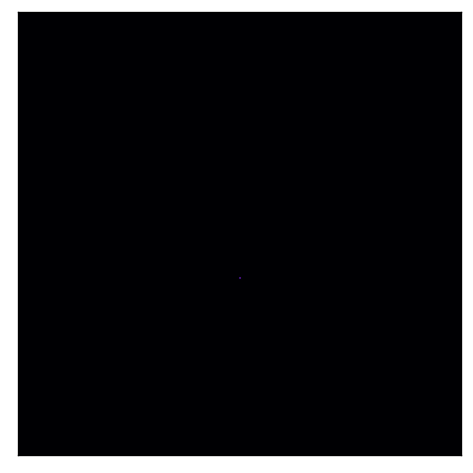

In [8]:
fig, ax  = plt.subplots(dpi=120)

img = infocus_simulator.image.array

ax.imshow(img, origin="lower", cmap="magma")
ax.set(xticks=[], yticks=[])

plt.show()

If you look very closely, you can see a small dot near below the center of the image.
That is our star!
Let's zoom in:

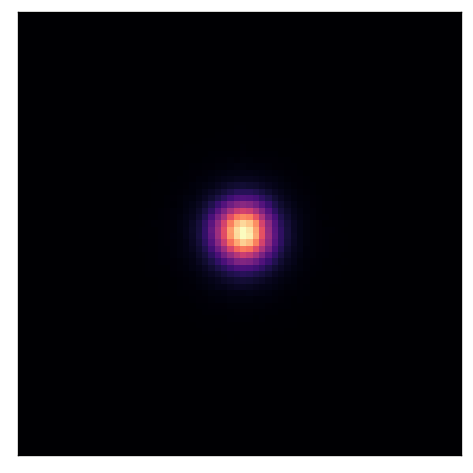

In [9]:
fig, ax  = plt.subplots(dpi=120)

# crop out a square segment around the star
img = infocus_simulator.image.array[1560:1630, 1965:2035]

ax.imshow(img, origin="lower", cmap="magma")
ax.set(xticks=[], yticks=[])

plt.show()

Zoomed in, you can see the Gaussian shape of the PSF.
You can also see the individual pixels.

This was an in-focus star.
Let's see what happens if we push the telescope out of focus.
We will do this by perturbing the position of M2 by 0.8 mm (M2 is the secondary mirror of the telescope).

In [7]:
# create a telescope identical to auxtel0,
# except with M2 offset by -0.8 mm = -0.0008 m
intra = auxtel0.withGloballyShiftedOptic(
    "M2", [0, 0, -0.0008] # meters
)
# create a simulator with this intrafocal telescope
intra_simulator = create_simulator(intra)
# simulate the star
intra_simulator.add_star(thx, thy, sed, flux, rng)

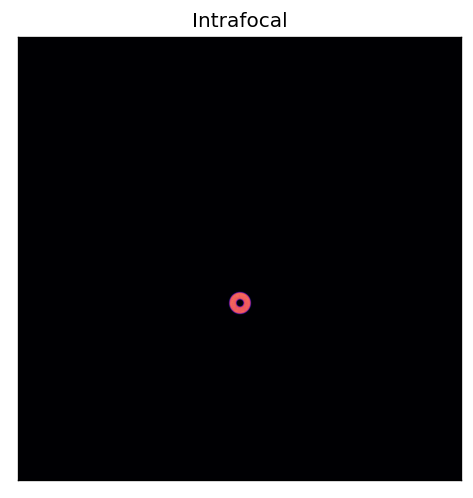

In [8]:
fig, ax  = plt.subplots(dpi=120)

img = intra_simulator.image.array
ax.imshow(img, origin="lower", cmap="magma")
ax.set(xticks=[], yticks=[], title="Intrafocal")

plt.show()

This intrafocal donut looks like a donut!
This is because out-of-focus objects look like the aperture of the telescope.
For the AuxTel, the "aperture" is just the primary mirror, which has the shape of a donut.

The primary mirror of AuxTel is a donut, because the AuxTel is a Cassegrain telescope.
The donut hole allows light to reach the focal plane, which is behind the primary:
![Cassegrain Telescope](https://upload.wikimedia.org/wikipedia/commons/b/b1/Cassegrain_Telescope.svg)

(Technically, the AuxTel has a third mirror behind the primary, that redirects the light to the side, like [this image](https://upload.wikimedia.org/wikipedia/commons/c/cd/Nasmyth-Telescope.svg). In other words, the AuxTel has a tertiary mirror and Nasmyth port behind the primary mirror.)


We can also simulate an extrafocal donut.
It looks very similar:

In [7]:
# create a telescope identical to auxtel0,
# except with M2 offset by +0.8 mm = +0.0008 m
extra = auxtel0.withGloballyShiftedOptic(
    "M2", [0, 0, +0.0008] # meters
)
# create a simulator with this intrafocal telescope
extra_simulator = create_simulator(extra)
# simulate the star
extra_simulator.add_star(thx, thy, sed, flux, rng)

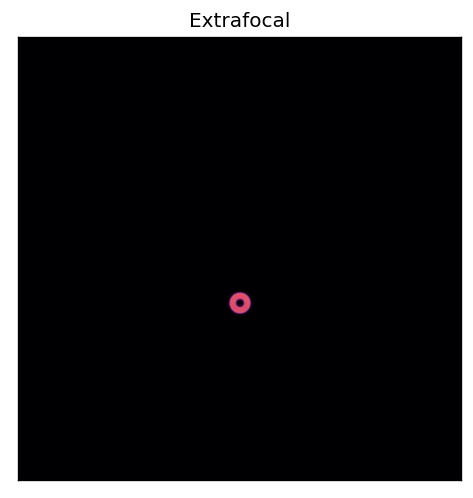

In [9]:
fig, ax  = plt.subplots(dpi=120)

img = extra_simulator.image.array
ax.imshow(img, origin="lower", cmap="magma")
ax.set(xticks=[], yticks=[], title="Extrafocal")

plt.show()

All of the previous simulations used a perfectly aligned telescope, but we are interested in cases where the telescope is not perfectly aligned.
Our goal is to use out-of-alignment images to infer the current state of the telescope, so that we can then put the telescope back into alignment.
We can do this by controlling the position and rotation of M2.

There are 5 parameters for M2 that we care about:
- 3 parameters for translations: $\Delta x$, $\Delta y$, $\Delta z$
- 2 parameters for rotation: $\theta_x$, $\theta_y$ (rotation angles about the x and y axes)

Let's create an out-of-alignment telescope and simulate an image to see what it looks like.

In [7]:
# first lets select some random translations
# I will simulate an intrafocal image, so I subtract 0.8mm from the z translation
M2_trans = np.array([
    rng.uniform(-0.001, 0.001),  # meters
    rng.uniform(-0.001, 0.001),
    rng.uniform(-0.0001, 0.0001) - 0.0008,
])

# now lets's select some random rotations
M2_rot = (
    batoid.RotX(np.deg2rad(rng.uniform(-0.1, 0.1)/60)) @
    batoid.RotY(np.deg2rad(rng.uniform(-0.1, 0.1)/60))
)

# now let's create a copy of the AuxTel with these perturbations
intra_perturbed = (
    auxtel0
    .withGloballyShiftedOptic("M2", M2_trans)
    .withLocallyRotatedOptic("M2", M2_rot)
)

Now let's simulate our star again!

In [8]:
# create a simulator with this intrafocal telescope
intra_perturbed_simulator = create_simulator(intra_perturbed)
# simulate the star
intra_perturbed_simulator.add_star(thx, thy, sed, flux, rng)

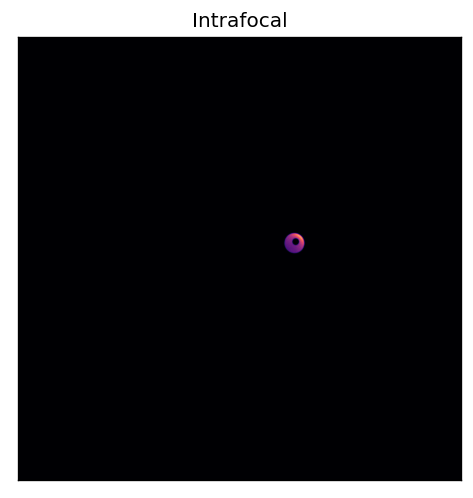

In [9]:
fig, ax  = plt.subplots(dpi=120)

img = intra_perturbed_simulator.image.array
ax.imshow(img, origin="lower", cmap="magma")
ax.set(xticks=[], yticks=[], title="Intrafocal")

plt.show()

See how the donut has changed locations, is not uniformly illuminated, and is not azimuthally symmetric?
These are all signs of the misalignment!
We can use all of these signatures to infer precisely in what way the telescope is misaligned. 

#### Bonus: Interactive visualization of bending modes

For these simulations, we have only concerned ourselves with optical misalignment.
However, for the larger Rubin Telescope, we also need to worry about the bending of the mirrors.
[This notebook](https://colab.research.google.com/drive/1YMh0B_hcBSm9cq02aQlyDHdGJv5fjmcV#scrollTo=NGznLCN7bHOg) on Google Colab provides an interactive demonstration of how the bending impacts the donut images.

If you run every cell (this takes a minute or two) and scroll down to the bottom, you will see plots of the "wavefront", and the intra- and extra-focal donut images.
Above these are fields where you can change the position of the donuts, as well as the mirror bending (Z4-Z34).
Try playing around with these to see how the donuts change.

This won't matter for what we are doing with AuxTel, but it is cool to see.